In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from IPython.display import display
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
import face_recognition
import cv2

IMAGESIZE = [200, 200]  # width (0) Height (1) 

In [40]:
# usage print(get_face_locations('nm0000001_rm946909184_1899-5-10_1968.jpg'))

def get_face_locations(imagePath): 
    image = face_recognition.load_image_file(imagePath)
    return face_recognition.face_locations(image)

# crop the image to just read the face location  
def crop_image(image, face_loc):
    return image[face_loc[1]:face_loc[3], face_loc[0]:face_loc[2]]  #  1 , 3, 0, 2

# resize the image to match the 
def resize_image(image):
    dsize = (IMAGESIZE[0], IMAGESIZE[1]) # width (0) Height (1) 
    return cv2.resize(image, dsize)

# function to  fetch the IMAGES from X(start) to Y(end) and returns three arrays  
def read_images_gender_Age(start, end, JSON_File, images_location):
    X=[]
    Y=[]
    Z=[]
    corrupted_entry = 0 
    for x in range(start, end+1):
        try:
            image = cv2.imread(images_location+JSON_File[x][3])
                
                # if the image is one of the corrupted image, skip this entry
            if(image.shape == (47,100,3) or image.shape == (1,1,3) or JSON_File[x][0] == "nan"):
                corrupted_entry +=1 
                continue
            
            face_loc = JSON_File[x][2]
            cropped_image = crop_image(image, face_loc)
            resized_image = resize_image(cropped_image)
            X.append(resized_image)
            Y.append(JSON_File[x][0]) # gender 
            Z.append(JSON_File[x][1]) # age
            #print(resized_image.shape)
            #plt.imshow(resized_image) 
            #plt.show()
        except Exception as e:
            print('ran into exception, skipping this entry, Error:', e)
            continue
            
    X = np.array(X)
    Y = np.array(Y).astype('float32')
    Y = keras.utils.to_categorical(Y)
    Z = np.array(Z).astype('float32')
    Z = keras.utils.to_categorical(Z, num_classes = 120)
    print('Read from ', start, ' to ', end, '. There were ',corrupted_entry, ' corrupted entry avoided')
    return X,Y,Z

#store the return of history in file
def store_history_inFile(history, start, end):
    try:
        json_object = json.load(open('./modelTrainingHistory.json'))
    except:
        json_object = []
        
    storage_file = open('./modelTrainingHistory.json', 'w')
    
    h5filename = str(0) + '-' + str(1000) + ':h5'
    
    json_object.append({"h5Filename": '1234H5',
            "start": start,
            "end": end,
            "duration": '3:00:00'})

    json.dump(json_object, storage_file)
    storage_file.close()
    
    

In [8]:
# load up the meta data Image paths 
imdb_jsonFile = json.load(open("imdb_outputdata.json"))
wiki_jsonFile = json.load(open("wiki_outputdata.json"))
imdb_file_location = '../imdb/'
wiki_file_location = '../wiki/'
imdbLen = len(imdb_jsonFile)
wikiLen = len(wiki_jsonFile)

In [62]:
X,Y,Z = read_images_gender_Age(0,1200,wiki_jsonFile,wiki_file_location)
print(X.shape)
print(Y.shape)

ran into exception, skipping this entry, Error: 'NoneType' object has no attribute 'shape'
Read from  0  to  1200 . There were  178  corrupted entry avoided
(1022, 200, 200, 3)
(1022, 2)


In [39]:
print(Z.shape)

(852, 113)


In [63]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(64, kernel_size=(2, 2),
 activation='relu',
 input_shape=[X.shape[1],
 X.shape[2],
 X.shape[3]]))
model.add(keras.layers.Conv2D(128, (2, 2), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(Y.shape[1], activation='softmax'))
model.compile(loss=keras.losses.CategoricalCrossentropy(),
 optimizer=keras.optimizers.Adam(),
 metrics=[keras.metrics.CategoricalAccuracy()])
model.summary()

batch_size = 25
epochs = 10
validation_split = 0.2

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 199, 199, 64)      832       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 198, 198, 128)     32896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 99, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 99, 99, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1254528)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               160579712 
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [64]:
history = model.fit(X, Y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split= validation_split)

Epoch 1/10
33/33 [==============================] - 92s 3s/step - loss: 818.7046 - categorical_accuracy: 0.6572 - val_loss: 0.7737 - val_categorical_accuracy: 0.6927
Epoch 2/10
33/33 [==============================] - 76s 2s/step - loss: 0.5627 - categorical_accuracy: 0.7848 - val_loss: 0.9803 - val_categorical_accuracy: 0.6976
Epoch 3/10
33/33 [==============================] - 74s 2s/step - loss: 0.4561 - categorical_accuracy: 0.8305 - val_loss: 0.8663 - val_categorical_accuracy: 0.6976
Epoch 4/10
33/33 [==============================] - 83s 3s/step - loss: 0.3172 - categorical_accuracy: 0.8636 - val_loss: 0.9948 - val_categorical_accuracy: 0.7073
Epoch 5/10
33/33 [==============================] - 78s 2s/step - loss: 0.2567 - categorical_accuracy: 0.9027 - val_loss: 1.8021 - val_categorical_accuracy: 0.7171
Epoch 6/10
33/33 [==============================] - 82s 2s/step - loss: 0.1457 - categorical_accuracy: 0.9543 - val_loss: 1.8486 - val_categorical_accuracy: 0.7268
Epoch 7/10
33/

In [65]:
predicitions  = model.predict(X[:,:,:,:])
men_classified_as_women = []
women_classified_as_men = []
for x in range(len(Y)):
    if(float(Y[x][1]) == 1.0 and float(predicitions[x][1]) < 0.5):
        men_classified_as_women.append(x)
        
for x in range(len(Y)):
    if(float(Y[x][0]) == 1.0 and float(predicitions[x][0]) < 0.5):
        women_classified_as_men.append(x)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
men_classified_as_women  2
women_classified_as_men  77


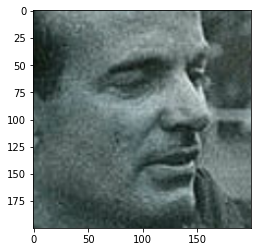

In [66]:
#1 0 female   0 1 male
plt.imshow(X[1,:,:,:]) 
#plt.show()
print(Y[:])
print('men_classified_as_women ', len(men_classified_as_women))
print('women_classified_as_men ',  len(women_classified_as_men))

showing Image at index - 38
[1. 0.]
[0.29110327 0.7088967 ]


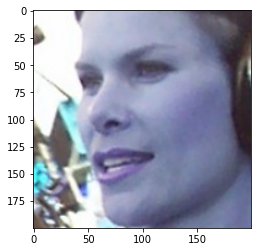

showing Image at index - 117
[1. 0.]
[0.25047728 0.7495227 ]


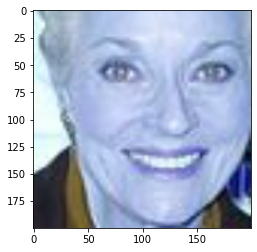

showing Image at index - 169
[1. 0.]
[0.1944849  0.80551505]


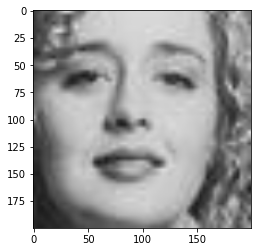

showing Image at index - 194
[1. 0.]
[0.27419204 0.72580796]


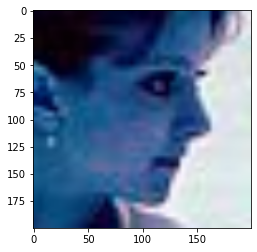

showing Image at index - 254
[1. 0.]
[0.19448493 0.80551505]


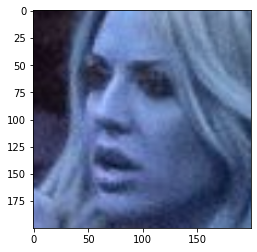

showing Image at index - 263
[1. 0.]
[0.1944849  0.80551505]


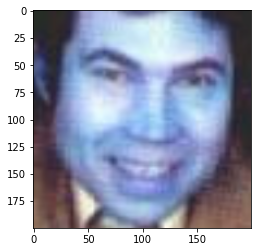

showing Image at index - 301
[1. 0.]
[0.31520945 0.68479055]


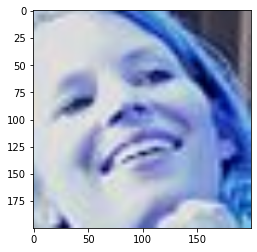

showing Image at index - 326
[1. 0.]
[0.1944849  0.80551505]


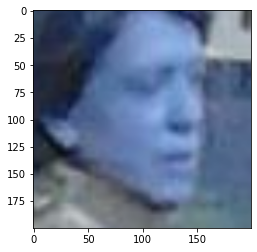

showing Image at index - 339
[1. 0.]
[0.3059081  0.69409186]


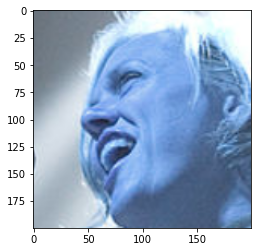

showing Image at index - 343
[1. 0.]
[0.4198079  0.58019215]


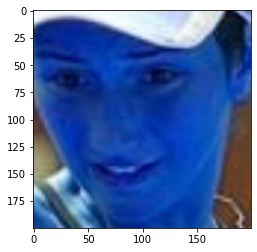

showing Image at index - 349
[1. 0.]
[0.19299467 0.8070053 ]


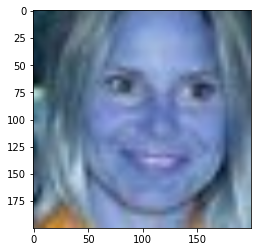

showing Image at index - 379
[1. 0.]
[0.1944849  0.80551505]


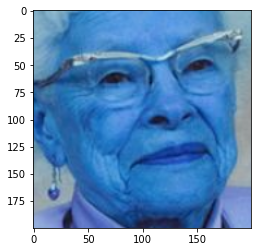

showing Image at index - 381
[1. 0.]
[0.35074386 0.64925605]


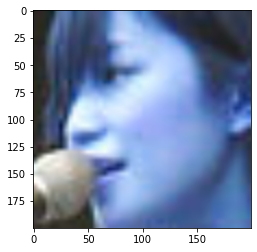

showing Image at index - 389
[1. 0.]
[0.1944849  0.80551505]


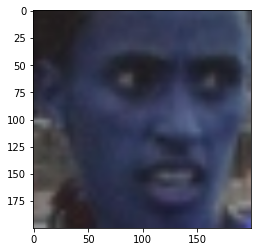

showing Image at index - 404
[1. 0.]
[0.1944849  0.80551505]


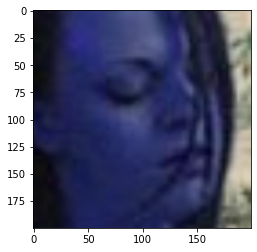

showing Image at index - 464
[1. 0.]
[0.1944849  0.80551505]


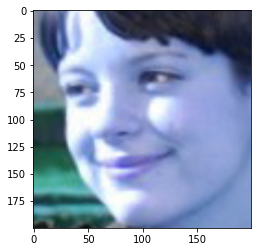

showing Image at index - 480
[1. 0.]
[0.2233187  0.77668124]


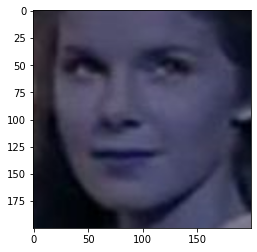

showing Image at index - 482
[1. 0.]
[0.24330951 0.7566905 ]


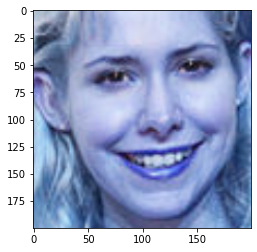

showing Image at index - 535
[1. 0.]
[0.30018753 0.6998125 ]


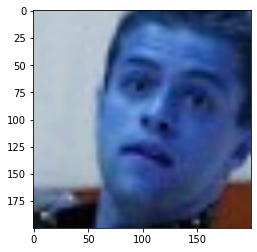

showing Image at index - 621
[1. 0.]
[0.1944849  0.80551505]


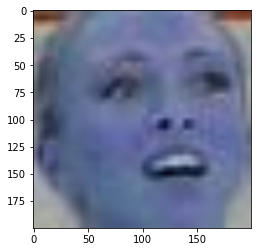

showing Image at index - 647
[1. 0.]
[0.1944849  0.80551505]


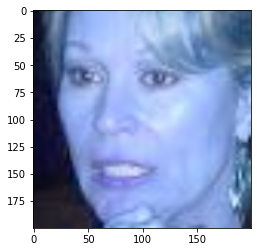

showing Image at index - 673
[1. 0.]
[0.36527064 0.6347293 ]


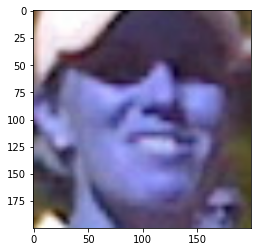

showing Image at index - 780
[1. 0.]
[0.1944849  0.80551505]


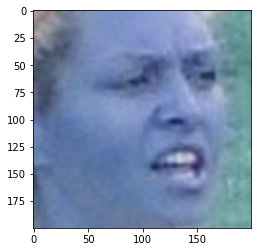

showing Image at index - 816
[1. 0.]
[0.45234105 0.547659  ]


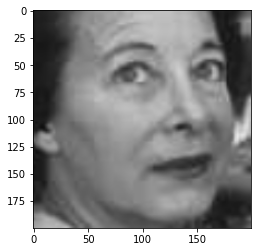

showing Image at index - 819
[1. 0.]
[0.05306924 0.94693077]


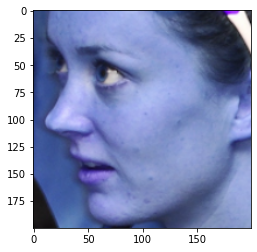

showing Image at index - 822
[1. 0.]
[0.03380398 0.96619594]


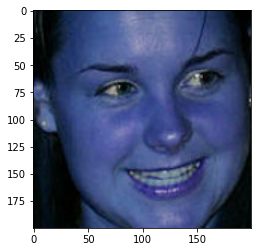

showing Image at index - 826
[1. 0.]
[0.1967159  0.80328417]


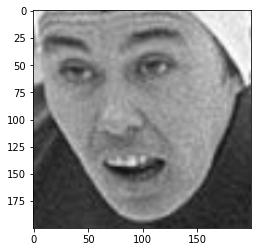

showing Image at index - 827
[1. 0.]
[0.01742559 0.9825744 ]


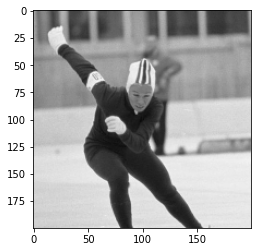

showing Image at index - 828
[1. 0.]
[1.0543392e-06 9.9999893e-01]


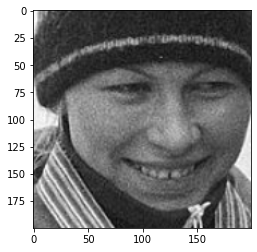

showing Image at index - 830
[1. 0.]
[0.22039193 0.7796081 ]


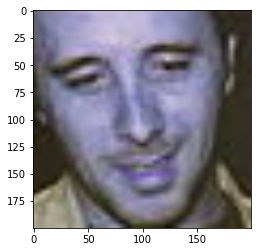

showing Image at index - 831
[1. 0.]
[4.9313589e-04 9.9950683e-01]


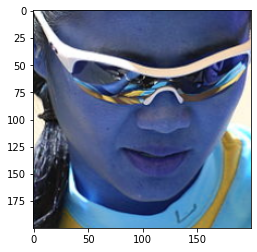

showing Image at index - 833
[1. 0.]
[0.16996838 0.8300316 ]


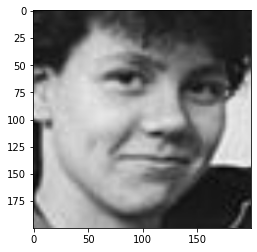

showing Image at index - 836
[1. 0.]
[0.24476041 0.7552396 ]


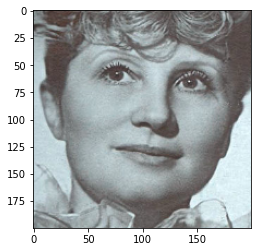

showing Image at index - 838
[1. 0.]
[0.00253043 0.99746954]


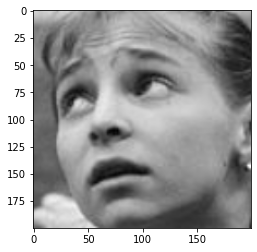

showing Image at index - 842
[1. 0.]
[0.27420163 0.72579837]


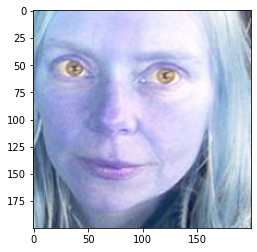

showing Image at index - 844
[1. 0.]
[0. 1.]


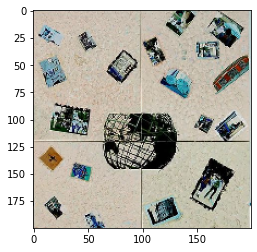

showing Image at index - 846
[1. 0.]
[0.08918501 0.910815  ]


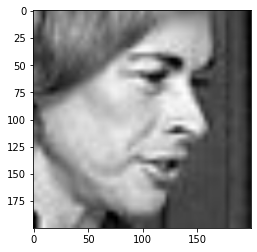

showing Image at index - 847
[1. 0.]
[0.0770494 0.9229506]


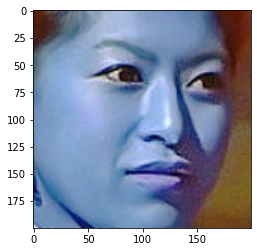

showing Image at index - 853
[1. 0.]
[0.30968803 0.69031197]


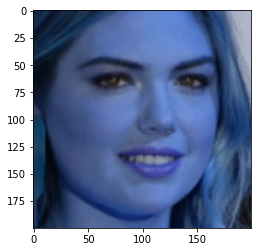

showing Image at index - 856
[1. 0.]
[0.1944849  0.80551505]


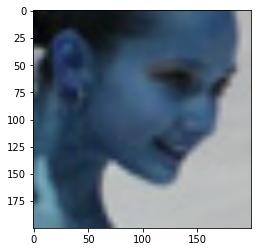

showing Image at index - 859
[1. 0.]
[0.19227917 0.80772084]


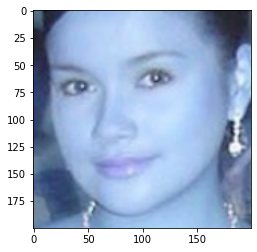

showing Image at index - 865
[1. 0.]
[0.00103472 0.99896526]


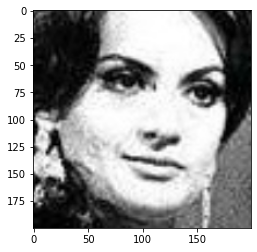

showing Image at index - 866
[1. 0.]
[5.234151e-04 9.994766e-01]


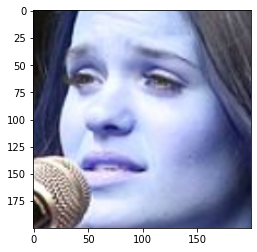

showing Image at index - 876
[1. 0.]
[3.851019e-10 1.000000e+00]


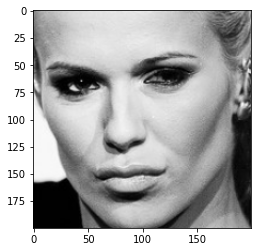

showing Image at index - 879
[1. 0.]
[0.1944849  0.80551505]


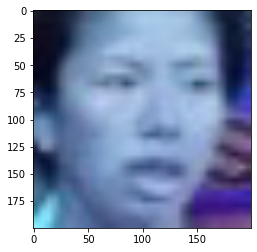

showing Image at index - 883
[1. 0.]
[0.14784443 0.8521555 ]


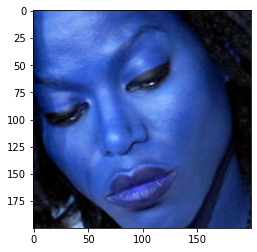

showing Image at index - 884
[1. 0.]
[0.20329325 0.79670674]


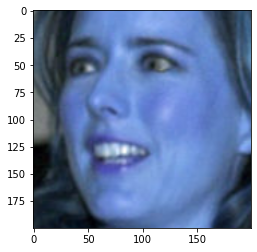

showing Image at index - 885
[1. 0.]
[0.1944849  0.80551505]


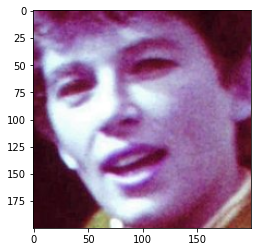

showing Image at index - 897
[1. 0.]
[0.1944849  0.80551505]


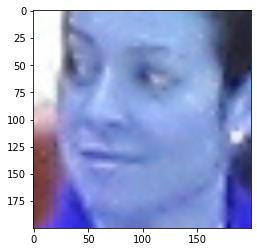

showing Image at index - 902
[1. 0.]
[0.13765597 0.86234397]


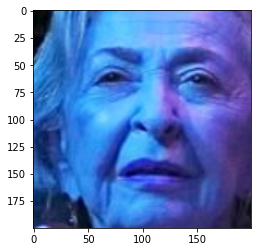

showing Image at index - 907
[1. 0.]
[0.0129441 0.9870559]


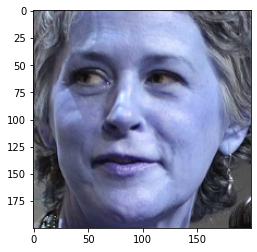

showing Image at index - 908
[1. 0.]
[0.18999644 0.81000364]


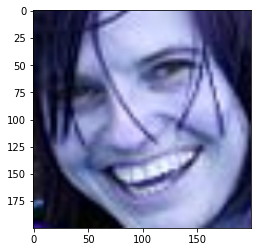

showing Image at index - 913
[1. 0.]
[0.17276451 0.8272355 ]


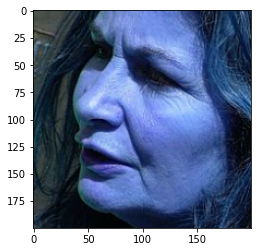

showing Image at index - 923
[1. 0.]
[7.481174e-07 9.999993e-01]


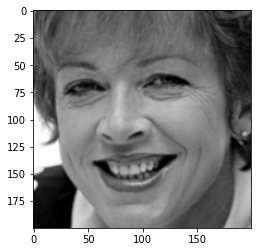

showing Image at index - 926
[1. 0.]
[0.17065477 0.8293452 ]


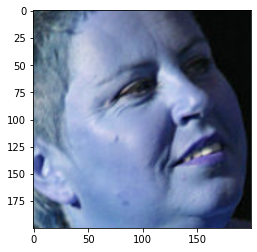

showing Image at index - 927
[1. 0.]
[0.13483226 0.8651678 ]


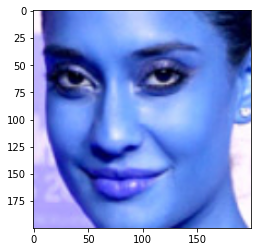

showing Image at index - 932
[1. 0.]
[0.2121111 0.7878889]


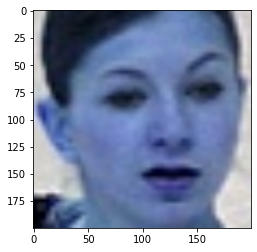

showing Image at index - 933
[1. 0.]
[0.20708711 0.7929129 ]


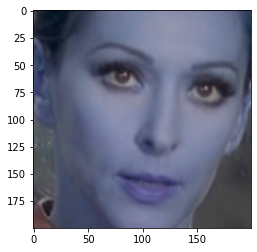

showing Image at index - 948
[1. 0.]
[1.8223575e-17 1.0000000e+00]


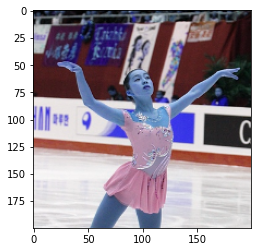

showing Image at index - 950
[1. 0.]
[0.19962144 0.8003786 ]


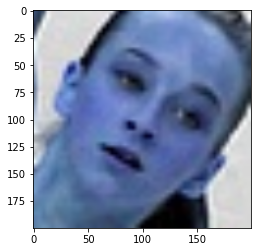

showing Image at index - 960
[1. 0.]
[0.11879209 0.88120794]


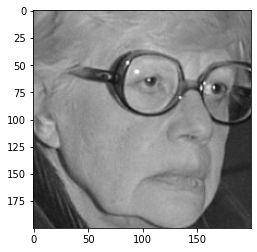

showing Image at index - 967
[1. 0.]
[0.00308229 0.9969177 ]


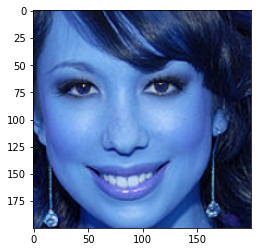

showing Image at index - 968
[1. 0.]
[0.01331631 0.98668367]


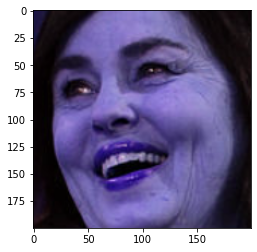

showing Image at index - 971
[1. 0.]
[0.1944849  0.80551505]


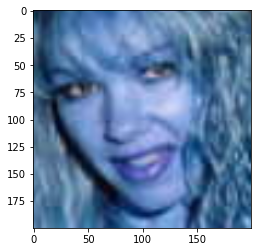

showing Image at index - 975
[1. 0.]
[0.2042835 0.7957165]


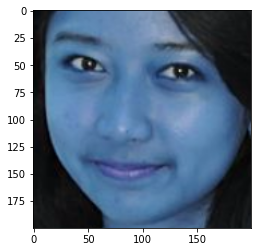

showing Image at index - 977
[1. 0.]
[0.01993828 0.9800617 ]


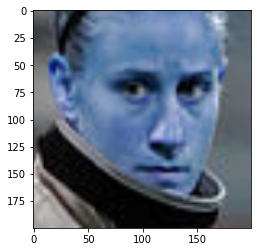

showing Image at index - 980
[1. 0.]
[0.1944849  0.80551505]


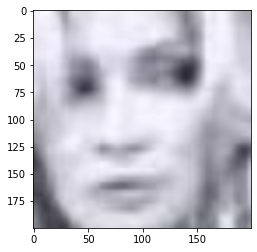

showing Image at index - 984
[1. 0.]
[0.2497267  0.75027335]


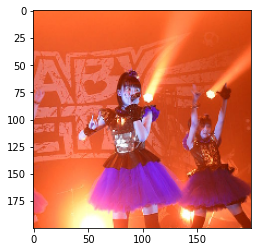

showing Image at index - 985
[1. 0.]
[3.8878094e-05 9.9996114e-01]


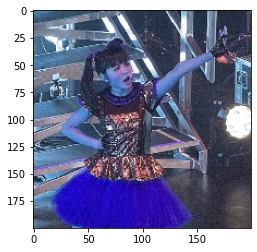

showing Image at index - 986
[1. 0.]
[0.21232292 0.78767705]


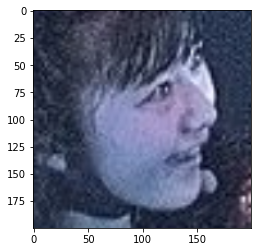

showing Image at index - 989
[1. 0.]
[0.18684928 0.81315076]


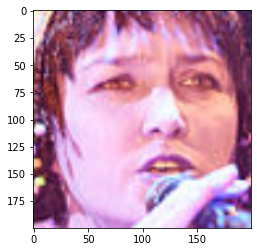

showing Image at index - 990
[1. 0.]
[0.02960978 0.9703902 ]


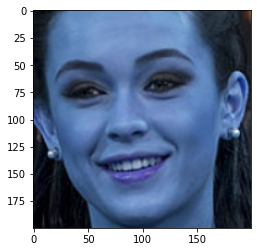

showing Image at index - 992
[1. 0.]
[1.6257216e-05 9.9998379e-01]


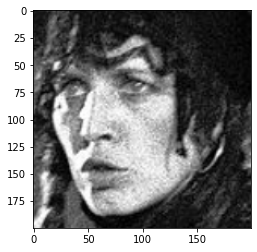

showing Image at index - 998
[1. 0.]
[0.49786404 0.50213593]


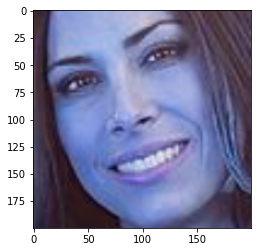

showing Image at index - 1005
[1. 0.]
[4.986743e-05 9.999502e-01]


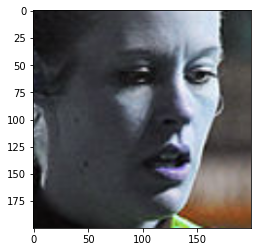

showing Image at index - 1008
[1. 0.]
[0.23597257 0.7640274 ]


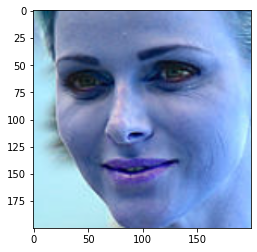

showing Image at index - 1015
[1. 0.]
[3.9832077e-08 1.0000000e+00]


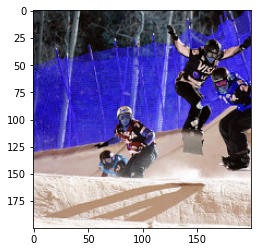

In [71]:
for x in range(len(women_classified_as_men)):
    print('showing Image at index -', women_classified_as_men[x])
    print(Y[women_classified_as_men[x]])
    print(predicitions[women_classified_as_men[x]])
    plt.imshow(X[women_classified_as_men[x],:,:,:])
    plt.show()

In [ ]:
plt.subplot(211)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss') 
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

In [11]:
# need a function that will
# store a training session history into a file inside the training history folder

In [10]:
# need a function that will read a file containing the last read index of training set, and return
# which index from the data set should the network be trained on next

In [12]:
# need to create a function that will store and load up the model from an h5 file

['1.0', '69', [1072, 161, 1214, 303], '01/nm0000001_rm124825600_1899-5-10_1968.jpg']
01/nm0000001_rm124825600_1899-5-10_1968.jpg
(200, 200, 3)


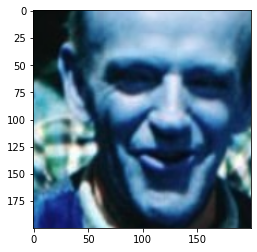

['1.0', '71', [477, 100, 622, 245], '01/nm0000001_rm3343756032_1899-5-10_1970.jpg']
01/nm0000001_rm3343756032_1899-5-10_1970.jpg
(200, 200, 3)


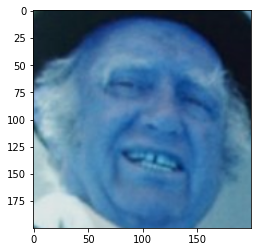

['1.0', '69', [114, 114, 451, 451], '01/nm0000001_rm577153792_1899-5-10_1968.jpg']
01/nm0000001_rm577153792_1899-5-10_1968.jpg
(200, 200, 3)


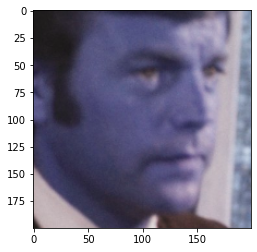

['1.0', '69', [622, 424, 844, 645], '01/nm0000001_rm946909184_1899-5-10_1968.jpg']
01/nm0000001_rm946909184_1899-5-10_1968.jpg
(200, 200, 3)


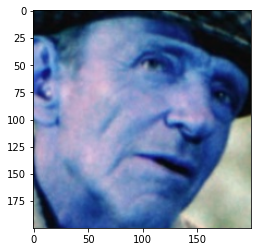

In [61]:
#type(imdb_jsonFile) THIS IS JUST FOR TESTTTTING 
counter = 0 
corrupted_images = 0 

for x in imdb_jsonFile:
    if counter < 4:
        print(x)
        print(x[3])
        image = cv2.imread(x[3])
        
        # if the image is one of the corrupted image, skip this entry
        if(image.shape == (47,100,3) or image.shape == (1,1,3)):
            corrupted_images +=1 
            continue
        
        face_loc = x[2]
        cropped_image = crop_image(image, face_loc)
        resized_image = resize_image(cropped_image)
        print(resized_image.shape)
        plt.imshow(resized_image) 
        plt.show()
    counter+=1


In [172]:
h5filename = str(0) + '-' + str(1000) + ':h5'

In [173]:
h5filename

'0-1000:h5'